In [ ]:
#相似度算法
#https://docs.pingcode.com/baike/1122809
#藥物分類器
#https://github.com/UzmaSayyeda/Pill-Identifier/blob/main/flask-app/models/best_model.ipynb
#keras模型架構選用
#https://keras.io/api/applications/

In [1]:
import numpy as np
#from keras.preprocessing import image #envir:TF272
import keras.utils as image #envir:PillNet
from keras.models import load_model, Model
#from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input

#from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
#from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

#from keras.applications.inception_v3 import InceptionV3, preprocess_input


#from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#from keras.applications.mobilenet import MobileNet, preprocess_input

#from keras.applications.efficientnet import EfficientNetB1, EfficientNetB2, EfficientNetB4, preprocess_input
#from keras.applications.efficientnet_v2 import EfficientNetV2S, EfficientNetV2B2, EfficientNetV2B3, preprocess_input

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import cv2
import matplotlib.pyplot as plt
import json
import tensorflow as tf

def load_and_preprocess_image(img_path):
    """
    加载并预处理图像：保持比例缩放后填充到 224x224。
    """
    # 加载图像
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    
    # 获取图像尺寸
    original_height, original_width, _ = img_array.shape
    
    # 目标尺寸
    target_size = (224, 224)
    target_height, target_width = target_size
    
    # 计算缩放比例
    scale = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)
    
    # 缩放图像
    resized_img = tf.image.resize(img_array, (new_height, new_width)).numpy()
    
    # 计算填充
    pad_top = (target_height - new_height) // 2
    pad_bottom = target_height - new_height - pad_top
    pad_left = (target_width - new_width) // 2
    pad_right = target_width - new_width - pad_left
    
    # 填充图像
    padded_img = np.pad(
        resized_img,
        ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
        mode='constant',
        constant_values=0  # 用黑色填充
    )
    plt.figure(figsize=(2, 2))
    plt.imshow(padded_img.astype(np.uint8))  # 转换为无符号整数类型以显示
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

    #錯的
    #padded_img = padded_img/255.0
    #對的:ResNet50
    padded_img = preprocess_input(padded_img)
    
    
    return np.expand_dims(padded_img, axis=0)  # 增加批次维度

def normalize_features(features):
    """
    將輸入的特徵向量進行L2歸一化。
    """
    return normalize(features.reshape(1, -1), norm='l2').flatten()

def calculate_euclidean_distance(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)
    
#CNN - 越像數字越大
#model = VGG16(weights='imagenet', include_top=False)  #BAD 71.3% 528MB inputsize= 224
#model = ResNet50(weights='imagenet', include_top=False)  #BAD 76% 98MB inputsize= 224

#Triplet loss訓練的ResNet50
model = load_model("ResNet50_checkpoints/1217_1_SE/epoch_139_val_loss_1.2474.h5")

#ResNet/255.050
#model = load_model("ResNet50_checkpoints/1207_1/epoch_36_val_loss_0.0582.h5")

#model = ResNet50V2(weights='imagenet', include_top=False)  #BAD 76% 98MB inputsize= 224
#model = InceptionResNetV2(weights='imagenet', include_top=False)  #BAD 80.3% 215MB inputsize= 299

#model = MobileNetV2(weights='imagenet', include_top=False)  #BAD 71.3% 14MB inputsize= 224 
#model = load_model("mobilenet_best_model.h5")

#model = InceptionV3(weights='imagenet', include_top=False)  #GOOD 77.9% 92MB inputsize= 299



#model = EfficientNetB1(weights='imagenet', include_top=False) #GOOD 79.1% 31MB inputsize=240
#model = EfficientNetB2(weights='imagenet', include_top=False) #3 小BAD  80.1% 36MB inputsize=260
#model = EfficientNetB4(weights='imagenet', include_top=False) #2 GOOD  82.9% 75MB inputsize=380

#model = EfficientNetV2B2(weights='imagenet', include_top=False)  #BAD 80.5% 59MB inputsize=260
#model = EfficientNetV2B3(weights='imagenet', include_top=False) #3 小BAD 82% 59MB inputsize=300

#model = EfficientNetV2S(weights='imagenet', include_top=False)  #1 BEST 83% 88MB inputsize=384

# 构建新的特征提取模型
#layer_name = 'mixed8'  # 选择一个中间层inceptionv3
#layer_name = 'conv_pw_13_relu' # MobileNet
#layer_name = 'conv3_block4_out' # Resnet50+catgroy
layer_name = 'dense_6'
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)


# 加載保存的類別映射
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

# 創建索引到類別名稱的反向映射
class_labels = {v: k for k, v in class_indices.items()}


In [2]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - {layer.output_shape}")

0: input_1 - [(None, 224, 224, 3)]
1: conv1_pad - (None, 230, 230, 3)
2: conv1_conv - (None, 112, 112, 64)
3: conv1_bn - (None, 112, 112, 64)
4: conv1_relu - (None, 112, 112, 64)
5: pool1_pad - (None, 114, 114, 64)
6: pool1_pool - (None, 56, 56, 64)
7: conv2_block1_1_conv - (None, 56, 56, 64)
8: conv2_block1_1_bn - (None, 56, 56, 64)
9: conv2_block1_1_relu - (None, 56, 56, 64)
10: conv2_block1_2_conv - (None, 56, 56, 64)
11: conv2_block1_2_bn - (None, 56, 56, 64)
12: conv2_block1_2_relu - (None, 56, 56, 64)
13: conv2_block1_0_conv - (None, 56, 56, 256)
14: conv2_block1_3_conv - (None, 56, 56, 256)
15: conv2_block1_0_bn - (None, 56, 56, 256)
16: conv2_block1_3_bn - (None, 56, 56, 256)
17: conv2_block1_add - (None, 56, 56, 256)
18: conv2_block1_out - (None, 56, 56, 256)
19: conv2_block2_1_conv - (None, 56, 56, 64)
20: conv2_block2_1_bn - (None, 56, 56, 64)
21: conv2_block2_1_relu - (None, 56, 56, 64)
22: conv2_block2_2_conv - (None, 56, 56, 64)
23: conv2_block2_2_bn - (None, 56, 56, 64)


S1A


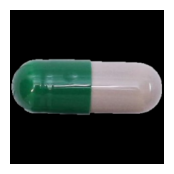

1A


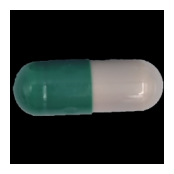

2A


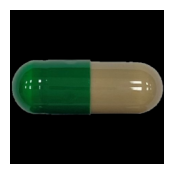

3A


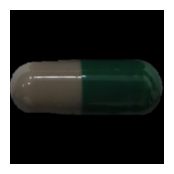

3A_T


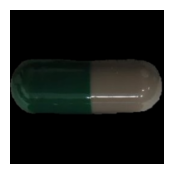

3A_T_A


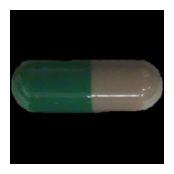

1/1 [==============================] - 2s 2s/step
54
Predicted class: c_020058
---feature_extractor---
(2048,)
SimilarityS1A + 1A: 0.74414146
SimilarityS1A + 2A: 0.519596
SimilarityS1A + 3A: 0.5703107
SimilarityS1A + 3A_T: 0.58635974
SimilarityS1A + 3A_T_A: 0.5707667
EucS1A + 1A : 23.868574
EucS1A + 2A : 31.862213
EucS1A + 3A : 31.497728
EucS1A + 3A_T : 32.56066
EucS1A + 3A_T_A : 32.8169
---model---
(1, 1845)
SimilarityS1A + 1A: 0.9679793
SimilarityS1A + 2A: 0.01161731
SimilarityS1A + 3A: 0.15013948
SimilarityS1A + 3A_T: 0.15007225
SimilarityS1A + 3A_T_A: 0.15056793


In [3]:
#膠囊種類-1
print("S1A")
img1 = load_and_preprocess_image('TestImg/capsule/1/Sample_16_1_A_GG.png')
print("1A")
img2 = load_and_preprocess_image('TestImg/capsule/1/16_1_A_GG.png')
print("2A")
img3 = load_and_preprocess_image('TestImg/capsule/1/16_2_A_GG.png')
print("3A")
img4 = load_and_preprocess_image('TestImg/capsule/1/16_3_A_GG.png')
print("3A_T")
img5 = load_and_preprocess_image('TestImg/capsule/1/16_3_A_GG_T.png')
print("3A_T_A")
img6 = load_and_preprocess_image('TestImg/capsule/1/16_3_A_GG_T_A.png')


predictions1 = model.predict(img1)
predicted_class_index1 = np.argmax(predictions1[0])
print(predicted_class_index1)
predicted_class_name1 = class_labels[predicted_class_index1]
print(f"Predicted class: {predicted_class_name1}")

#for inceptionv3
print("---feature_extractor---")
features1 = feature_extractor.predict(img1,verbose=0).flatten()
features2 = feature_extractor.predict(img2,verbose=0).flatten()
features3 = feature_extractor.predict(img3,verbose=0).flatten()
features4 = feature_extractor.predict(img4,verbose=0).flatten()
features5 = feature_extractor.predict(img5,verbose=0).flatten()
features6 = feature_extractor.predict(img6,verbose=0).flatten()
print(features6.shape)
similarity1 = cosine_similarity([features1], [features2])[0][0]
similarity2 = cosine_similarity([features1], [features3])[0][0]
similarity3 = cosine_similarity([features1], [features4])[0][0]
similarity4 = cosine_similarity([features1], [features5])[0][0]
similarity5 = cosine_similarity([features1], [features6])[0][0]

print("SimilarityS1A + 1A:", similarity1)
print("SimilarityS1A + 2A:", similarity2)
print("SimilarityS1A + 3A:", similarity3)
print("SimilarityS1A + 3A_T:", similarity4)
print("SimilarityS1A + 3A_T_A:", similarity5)

#通用
euc1 = calculate_euclidean_distance(features1, features2)
euc2 = calculate_euclidean_distance(features1, features3)
euc3 = calculate_euclidean_distance(features1, features4)
euc4 = calculate_euclidean_distance(features1, features5)
euc5 = calculate_euclidean_distance(features1, features6)
print("EucS1A + 1A :", euc1)
print("EucS1A + 2A :", euc2)
print("EucS1A + 3A :", euc3)
print("EucS1A + 3A_T :", euc4)
print("EucS1A + 3A_T_A :", euc5)

#for resnet50 + triplet loss
print("---model---")
features1 = model.predict(img1,verbose=0)
features2 = model.predict(img2,verbose=0)
features3 = model.predict(img3,verbose=0)
features4 = model.predict(img4,verbose=0)
features5 = model.predict(img5,verbose=0)
features6 = model.predict(img6,verbose=0)
print(features6.shape)
#給resnet50 + triplet loss用
similarity1 = cosine_similarity(features1, features2)[0][0]
similarity2 = cosine_similarity(features1, features3)[0][0]
similarity3 = cosine_similarity(features1, features4)[0][0]
similarity4 = cosine_similarity(features1, features5)[0][0]
similarity5 = cosine_similarity(features1, features6)[0][0]
print("SimilarityS1A + 1A:", similarity1)
print("SimilarityS1A + 2A:", similarity2)
print("SimilarityS1A + 3A:", similarity3)
print("SimilarityS1A + 3A_T:", similarity4)
print("SimilarityS1A + 3A_T_A:", similarity5)

S1A


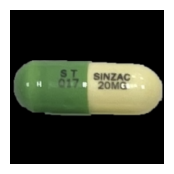

S1B


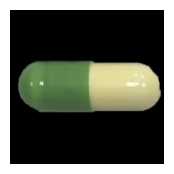

1A


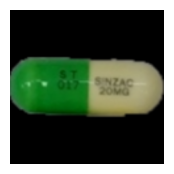

1B


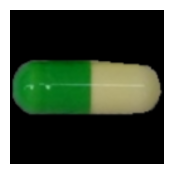

2A


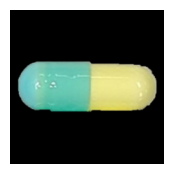

2B


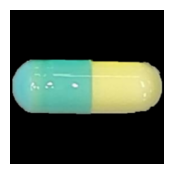

3A


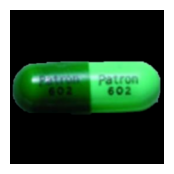

3B


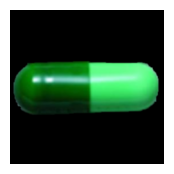

1/1 [==============================] - 0s 31ms/step
232
Predicted class: c_041606
---feature_extractor---
SimilarityS1A + S1B: 0.739951
SimilarityS1A + 1A: 0.54307944
SimilarityS1A + 1B: 0.4851039
SimilarityS1A + 2A: 0.555569
SimilarityS1A + 2B: 0.54728055
SimilarityS1A + 3A: 0.36841738
SimilarityS1A + 3B: 0.32994112
---
SimilarityS1B + 1A: 0.6071031
SimilarityS1B + 1B: 0.53657675
SimilarityS1B + 2A: 0.59127724
SimilarityS1B + 2B: 0.5532826
SimilarityS1B + 3A: 0.32600105
SimilarityS1B + 3B: 0.39303756
EucS1A + S1B: 25.322065
EucS1A + 1A: 32.6179
EucS1A + 1B: 33.796314
EucS1A + 2A: 30.548458
EucS1A + 2B: 30.702538
EucS1A + 3A: 33.534626
EucS1A + 3B: 35.236797
---
EucS1B + 1A: 32.79502
EucS1B + 1B: 35.054417
EucS1B + 2A: 32.31909
EucS1B + 2B: 33.68109
EucS1B + 3A: 39.04817
EucS1B + 3B: 37.651836
---model---
SimilarityS1A + S1B: 0.29903933
SimilarityS1A + 1A: 0.018263863
SimilarityS1A + 1B: 0.008215509
SimilarityS1A + 2A: 0.0004807305
SimilarityS1A + 2B: 0.00015265463
SimilarityS1A + 3A: 

In [4]:
#膠囊種類-2
print("S1A")
img1 = load_and_preprocess_image('TestImg/capsule/2/Sample_15_1_A_GW.png')
print("S1B")
img2 = load_and_preprocess_image('TestImg/capsule/2/Sample_15_1_B_GW.png')
print("1A")
img3 = load_and_preprocess_image('TestImg/capsule/2/15_1_A_GW.png')
print("1B")
img4 = load_and_preprocess_image('TestImg/capsule/2/15_1_B_GW.png')
print("2A")
img5 = load_and_preprocess_image('TestImg/capsule/2/15_2_A_GW.png')
print("2B")
img6 = load_and_preprocess_image('TestImg/capsule/2/15_2_B_GW.png')
print("3A")
img7 = load_and_preprocess_image('TestImg/capsule/2/15_3_A_GW.png')
print("3B")
img8 = load_and_preprocess_image('TestImg/capsule/2/15_3_B_GW.png')

predictions1 = model.predict(img1)
predicted_class_index1 = np.argmax(predictions1[0])
print(predicted_class_index1)
predicted_class_name1 = class_labels[predicted_class_index1]
print(f"Predicted class: {predicted_class_name1}")

#for inceptionv3
print("---feature_extractor---")
features1 = feature_extractor.predict(img1,verbose=0).flatten()
features2 = feature_extractor.predict(img2,verbose=0).flatten()
features3 = feature_extractor.predict(img3,verbose=0).flatten()
features4 = feature_extractor.predict(img4,verbose=0).flatten()
features5 = feature_extractor.predict(img5,verbose=0).flatten()
features6 = feature_extractor.predict(img6,verbose=0).flatten()
features7 = feature_extractor.predict(img7,verbose=0).flatten()
features8 = feature_extractor.predict(img8,verbose=0).flatten()
similarity1 = cosine_similarity([features1], [features2])[0][0]
similarity2 = cosine_similarity([features1], [features3])[0][0]
similarity3 = cosine_similarity([features1], [features4])[0][0]
similarity4 = cosine_similarity([features1], [features5])[0][0]
similarity5 = cosine_similarity([features1], [features6])[0][0]
similarity6 = cosine_similarity([features1], [features7])[0][0]
similarity7 = cosine_similarity([features1], [features8])[0][0]
print("SimilarityS1A + S1B:", similarity1)
print("SimilarityS1A + 1A:", similarity2)
print("SimilarityS1A + 1B:", similarity3)
print("SimilarityS1A + 2A:", similarity4)
print("SimilarityS1A + 2B:", similarity5)
print("SimilarityS1A + 3A:", similarity6)
print("SimilarityS1A + 3B:", similarity7)
print('---')
similarity8 = cosine_similarity([features2], [features3])[0][0]
similarity9 = cosine_similarity([features2], [features4])[0][0]
similarity10 = cosine_similarity([features2], [features5])[0][0]
similarity11 = cosine_similarity([features2], [features6])[0][0]
similarity12 = cosine_similarity([features2], [features7])[0][0]
similarity13 = cosine_similarity([features2], [features8])[0][0]
print("SimilarityS1B + 1A:", similarity8)
print("SimilarityS1B + 1B:", similarity9)
print("SimilarityS1B + 2A:", similarity10)
print("SimilarityS1B + 2B:", similarity11)
print("SimilarityS1B + 3A:", similarity12)
print("SimilarityS1B + 3B:", similarity13)

#通用
euc1 = calculate_euclidean_distance(features1, features2)
euc2 = calculate_euclidean_distance(features1, features3)
euc3 = calculate_euclidean_distance(features1, features4)
euc4 = calculate_euclidean_distance(features1, features5)
euc5 = calculate_euclidean_distance(features1, features6)
euc6 = calculate_euclidean_distance(features1, features7)
euc7 = calculate_euclidean_distance(features1, features8)
print("EucS1A + S1B:", euc1)
print("EucS1A + 1A:", euc2)
print("EucS1A + 1B:", euc3)
print("EucS1A + 2A:", euc4)
print("EucS1A + 2B:", euc5)
print("EucS1A + 3A:", euc6)
print("EucS1A + 3B:", euc7)
print('---')
euc8 = calculate_euclidean_distance(features2, features3)
euc9 = calculate_euclidean_distance(features2, features4)
euc10 = calculate_euclidean_distance(features2, features5)
euc11 = calculate_euclidean_distance(features2, features6)
euc12 = calculate_euclidean_distance(features2, features7)
euc13 = calculate_euclidean_distance(features2, features8)
print("EucS1B + 1A:", euc8)
print("EucS1B + 1B:", euc9)
print("EucS1B + 2A:", euc10)
print("EucS1B + 2B:", euc11)
print("EucS1B + 3A:", euc12)
print("EucS1B + 3B:", euc13)

#for resnet50 + triplet loss 
print("---model---")
features1 = model.predict(img1,verbose=0)
features2 = model.predict(img2,verbose=0)
features3 = model.predict(img3,verbose=0)
features4 = model.predict(img4,verbose=0)
features5 = model.predict(img5,verbose=0)
features6 = model.predict(img6,verbose=0)
features7 = model.predict(img7,verbose=0)
features8 = model.predict(img8,verbose=0)
similarity1 = cosine_similarity(features1, features2)[0][0]
similarity2 = cosine_similarity(features1, features3)[0][0]
similarity3 = cosine_similarity(features1, features4)[0][0]
similarity4 = cosine_similarity(features1, features5)[0][0]
similarity5 = cosine_similarity(features1, features6)[0][0]
similarity6 = cosine_similarity(features1, features7)[0][0]
similarity7 = cosine_similarity(features1, features8)[0][0]
print("SimilarityS1A + S1B:", similarity1)
print("SimilarityS1A + 1A:", similarity2)
print("SimilarityS1A + 1B:", similarity3)
print("SimilarityS1A + 2A:", similarity4)
print("SimilarityS1A + 2B:", similarity5)
print("SimilarityS1A + 3A:", similarity6)
print("SimilarityS1A + 3B:", similarity7)
print('---')
similarity8 = cosine_similarity(features2, features3)[0][0]
similarity9 = cosine_similarity(features2, features4)[0][0]
similarity10 = cosine_similarity(features2, features5)[0][0]
similarity11 = cosine_similarity(features2, features6)[0][0]
similarity12 = cosine_similarity(features2, features7)[0][0]
similarity13 = cosine_similarity(features2, features8)[0][0]
print("SimilarityS1B + 1A:", similarity8)
print("SimilarityS1B + 1B:", similarity9)
print("SimilarityS1B + 2A:", similarity10)
print("SimilarityS1B + 2B:", similarity11)
print("SimilarityS1B + 3A:", similarity12)
print("SimilarityS1B + 3B:", similarity13)

S1A


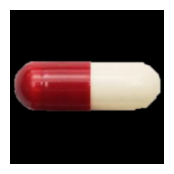

1A


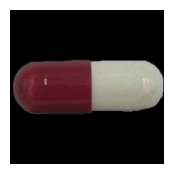

2A


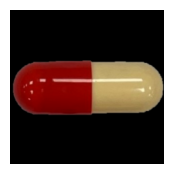

3A


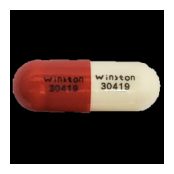

3B


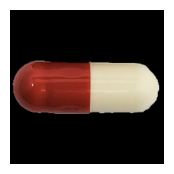

1/1 [==============================] - 0s 23ms/step
333
Predicted class: c_057120
---feature_extractor---
SimilarityS1A + 1A: 0.61387336
SimilarityS1A + 2A: 0.44653845
SimilarityS1A + 3A: 0.37394065
SimilarityS1A + 3B: 0.534117
EucS1A + 1A: 26.446135
EucS1A + 2A: 31.897284
EucS1A + 3B: 34.643333
EucS1A + 3B: 30.030514
---model---
SimilarityS1A + 1A: 0.04957292
SimilarityS1A + 2A: 0.021132503
SimilarityS1A + 3A: 0.08500678
SimilarityS1A + 3B: 0.08533621


In [5]:
#膠囊種類-3
print("S1A")
img1 = load_and_preprocess_image('TestImg/capsule/3/Sample_18_1_A_RW.png')
print("1A")
img2 = load_and_preprocess_image('TestImg/capsule/3/18_1_A_RG.png')
print("2A")
img3 = load_and_preprocess_image('TestImg/capsule/3/18_2_A_RW.png')
print("3A")
img4 = load_and_preprocess_image('TestImg/capsule/3/18_3_A_RW.png')
print("3B")
img5 = load_and_preprocess_image('TestImg/capsule/3/18_3_B_RW.png')

predictions1 = model.predict(img1)
predicted_class_index1 = np.argmax(predictions1[0])
print(predicted_class_index1)
predicted_class_name1 = class_labels[predicted_class_index1]
print(f"Predicted class: {predicted_class_name1}")

#for inceptionv3
print("---feature_extractor---")
features1 = feature_extractor.predict(img1,verbose=0).flatten()
features2 = feature_extractor.predict(img2,verbose=0).flatten()
features3 = feature_extractor.predict(img3,verbose=0).flatten()
features4 = feature_extractor.predict(img4,verbose=0).flatten()
features5 = feature_extractor.predict(img5,verbose=0).flatten()
similarity1 = cosine_similarity([features1], [features2])[0][0]
similarity2 = cosine_similarity([features1], [features3])[0][0]
similarity3 = cosine_similarity([features1], [features4])[0][0]
similarity4 = cosine_similarity([features1], [features5])[0][0]
print("SimilarityS1A + 1A:", similarity1)
print("SimilarityS1A + 2A:", similarity2)
print("SimilarityS1A + 3A:", similarity3)
print("SimilarityS1A + 3B:", similarity4)

#通用
euc1 = calculate_euclidean_distance(features1, features2)
euc2 = calculate_euclidean_distance(features1, features3)
euc3 = calculate_euclidean_distance(features1, features4)
euc4 = calculate_euclidean_distance(features1, features5)
print("EucS1A + 1A:", euc1)
print("EucS1A + 2A:", euc2)
print("EucS1A + 3B:", euc3)
print("EucS1A + 3B:", euc4)

#for resnet50 + triplet loss 
print("---model---")
features1 = model.predict(img1,verbose=0)
features2 = model.predict(img2,verbose=0)
features3 = model.predict(img3,verbose=0)
features4 = model.predict(img4,verbose=0)
features5 = model.predict(img5,verbose=0)
similarity1 = cosine_similarity(features1, features2)[0][0]
similarity2 = cosine_similarity(features1, features3)[0][0]
similarity3 = cosine_similarity(features1, features4)[0][0]
similarity4 = cosine_similarity(features1, features5)[0][0]
print("SimilarityS1A + 1A:", similarity1)
print("SimilarityS1A + 2A:", similarity2)
print("SimilarityS1A + 3A:", similarity3)
print("SimilarityS1A + 3B:", similarity4)

S1A


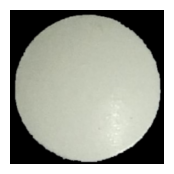

S1B


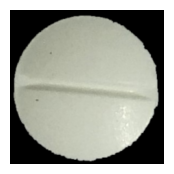

1A


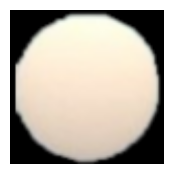

1B


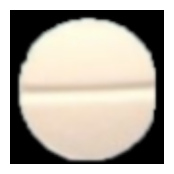

2A


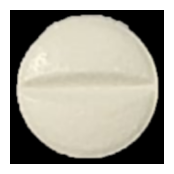

2B


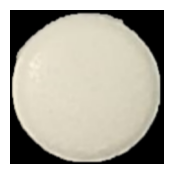

3B


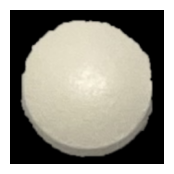

1/1 [==============================] - 0s 44ms/step
858
Predicted class: p_rou_001728
---feature_extractor---
SimilarityS1A + S1B: 0.6923316
SimilarityS1A + 1A: 0.39113086
SimilarityS1A + 1B: 0.3492793
SimilarityS1A + 2A: 0.43762255
SimilarityS1A + 2B: 0.45609397
SimilarityS1A + 3B: 0.64130867
---
SimilarityS1B + 1A: 0.27612406
SimilarityS1B + 1B: 0.35741752
SimilarityS1B + 2A: 0.47316977
SimilarityS1B + 2B: 0.34097493
SimilarityS1B + 3B: 0.5098367
EucS1A + S1B: 34.41761
EucS1A + 1A: 61.7204
EucS1A + 1B: 61.231686
EucS1A + 2S: 48.122078
EucS1A + 2B: 45.958786
EucS1A + 3B: 37.70565
---
EucS1B + 1A: 66.29134
EucS1B + 1B: 60.417263
EucS1B + 2A: 45.988255
EucS1B + 2B: 49.870785
EucS1B + 3B: 43.477337
---model---
SimilarityS1A + S1B: 0.9733576
SimilarityS1A + 1A: 0.010895131
SimilarityS1A + 1B: 0.008572513
SimilarityS1A + 2A: 0.041507237
SimilarityS1A + 2B: 0.037937302
SimilarityS1A + 3B: 0.015102339
---
SimilarityS1B + 1A: 0.0037844416
SimilarityS1B + 1B: 0.0045960196
SimilarityS1B + 2A: 0

In [6]:
#藥丸種類-1
print("S1A")
img1 = load_and_preprocess_image('TestImg/pill/1/Sample_8_1_A_W.png')
print("S1B")
img2 = load_and_preprocess_image('TestImg/pill/1/Sample_8_1_B_W.png')
print("1A")
img3 = load_and_preprocess_image('TestImg/pill/1/8_1_A_W.png')
print("1B")
img4 = load_and_preprocess_image('TestImg/pill/1/8_1_B_W.png')
#img3 = load_and_preprocess_image('TestImg/pill/1/A.png')
#img4 = load_and_preprocess_image('TestImg/pill/1/B.png')
print("2A")
img5 = load_and_preprocess_image('TestImg/pill/1/8_2_A_W.png')
print("2B")
img6 = load_and_preprocess_image('TestImg/pill/1/8_2_B_W.png')
print("3B")
img7 = load_and_preprocess_image('TestImg/pill/1/8_3_B_W.png')

predictions1 = model.predict(img1)
predicted_class_index1 = np.argmax(predictions1[0])
print(predicted_class_index1)
predicted_class_name1 = class_labels[predicted_class_index1]
print(f"Predicted class: {predicted_class_name1}")

#for inceptionv3
print("---feature_extractor---")
features1 = feature_extractor.predict(img1,verbose=0).flatten()
features2 = feature_extractor.predict(img2,verbose=0).flatten()
features3 = feature_extractor.predict(img3,verbose=0).flatten()
features4 = feature_extractor.predict(img4,verbose=0).flatten()
features5 = feature_extractor.predict(img5,verbose=0).flatten()
features6 = feature_extractor.predict(img6,verbose=0).flatten()
features7 = feature_extractor.predict(img7,verbose=0).flatten()

similarity1 = cosine_similarity([features1], [features2])[0][0]
similarity2 = cosine_similarity([features1], [features3])[0][0]
similarity3 = cosine_similarity([features1], [features4])[0][0]
similarity4 = cosine_similarity([features1], [features5])[0][0]
similarity5 = cosine_similarity([features1], [features6])[0][0]
similarity6 = cosine_similarity([features1], [features7])[0][0]
print("SimilarityS1A + S1B:", similarity1)
print("SimilarityS1A + 1A:", similarity2)
print("SimilarityS1A + 1B:", similarity3)
print("SimilarityS1A + 2A:", similarity4)
print("SimilarityS1A + 2B:", similarity5)
print("SimilarityS1A + 3B:", similarity6)
print("---")
similarity7 = cosine_similarity([features2], [features3])[0][0]
similarity8 = cosine_similarity([features2], [features4])[0][0]
similarity9 = cosine_similarity([features2], [features5])[0][0]
similarity10 = cosine_similarity([features2], [features6])[0][0]
similarity11 = cosine_similarity([features2], [features7])[0][0]
print("SimilarityS1B + 1A:", similarity7)
print("SimilarityS1B + 1B:", similarity8)
print("SimilarityS1B + 2A:", similarity9)
print("SimilarityS1B + 2B:", similarity10)
print("SimilarityS1B + 3B:", similarity11)

#通用
euc1 = calculate_euclidean_distance(features1, features2)
euc2 = calculate_euclidean_distance(features1, features3)
euc3 = calculate_euclidean_distance(features1, features4)
euc4 = calculate_euclidean_distance(features1, features5)
euc5 = calculate_euclidean_distance(features1, features6)
euc6 = calculate_euclidean_distance(features1, features7)
print("EucS1A + S1B:", euc1)
print("EucS1A + 1A:", euc2)
print("EucS1A + 1B:", euc3)
print("EucS1A + 2S:", euc4)
print("EucS1A + 2B:", euc5)
print("EucS1A + 3B:", euc6)
print("---")
euc7 = calculate_euclidean_distance(features2, features3)
euc8 = calculate_euclidean_distance(features2, features4)
euc9 = calculate_euclidean_distance(features2, features5)
euc10 = calculate_euclidean_distance(features2, features6)
euc11 = calculate_euclidean_distance(features2, features7)
print("EucS1B + 1A:", euc7)
print("EucS1B + 1B:", euc8)
print("EucS1B + 2A:", euc9)
print("EucS1B + 2B:", euc10)
print("EucS1B + 3B:", euc11)

#for resnet50 + triplet loss 
print("---model---")
features1 = model.predict(img1,verbose=0)
features2 = model.predict(img2,verbose=0)
features3 = model.predict(img3,verbose=0)
features4 = model.predict(img4,verbose=0)
features5 = model.predict(img5,verbose=0)
features6 = model.predict(img6,verbose=0)
features7 = model.predict(img7,verbose=0)

similarity1 = cosine_similarity(features1, features2)[0][0]
similarity2 = cosine_similarity(features1, features3)[0][0]
similarity3 = cosine_similarity(features1, features4)[0][0]
similarity4 = cosine_similarity(features1, features5)[0][0]
similarity5 = cosine_similarity(features1, features6)[0][0]
similarity6 = cosine_similarity(features1, features7)[0][0]
print("SimilarityS1A + S1B:", similarity1)
print("SimilarityS1A + 1A:", similarity2)
print("SimilarityS1A + 1B:", similarity3)
print("SimilarityS1A + 2A:", similarity4)
print("SimilarityS1A + 2B:", similarity5)
print("SimilarityS1A + 3B:", similarity6)
print("---")
similarity7 = cosine_similarity(features2, features3)[0][0]
similarity8 = cosine_similarity(features2, features4)[0][0]
similarity9 = cosine_similarity(features2, features5)[0][0]
similarity10 = cosine_similarity(features2, features6)[0][0]
similarity11 = cosine_similarity(features2, features7)[0][0]
print("SimilarityS1B + 1A:", similarity7)
print("SimilarityS1B + 1B:", similarity8)
print("SimilarityS1B + 2A:", similarity9)
print("SimilarityS1B + 2B:", similarity10)
print("SimilarityS1B + 3B:", similarity11)


S1A


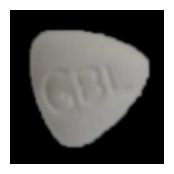

S1B


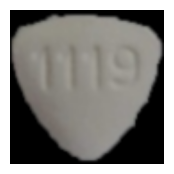

S1A_T


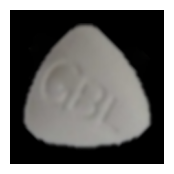

1A


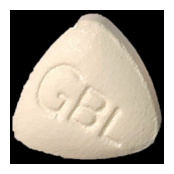

1B


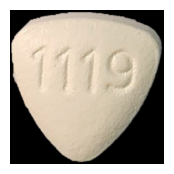

2A


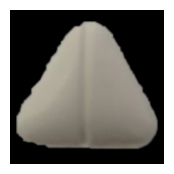

2B


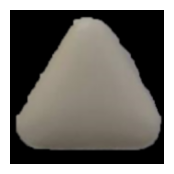

3A


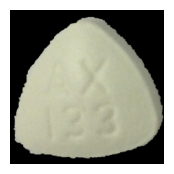

3B


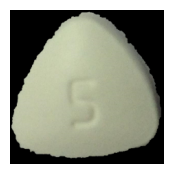

1/1 [==============================] - 0s 31ms/step
947
Predicted class: p_rou_012707
---feature_extractor---
SimilarityS1A + S1B: 0.6546849
SimilarityS1A + S1A_T: 0.9459702
SimilarityS1A + 1A: 0.2628922
SimilarityS1A + 1B: 0.26615044
SimilarityS1A + 2A: 0.42366588
SimilarityS1A + 2B: 0.41177213
SimilarityS1A + 3A: 0.30812114
SimilarityS1A + 3B: 0.2768104
---
SimilarityS1B + S1A_T: 0.6528652
SimilarityS1B + 1A: 0.33321863
SimilarityS1B + 1B: 0.41925976
SimilarityS1B + 2A: 0.4640205
SimilarityS1B + 2B: 0.4640986
SimilarityS1B + 3A: 0.31315613
SimilarityS1B + 3B: 0.3498
---
SimilarityS1A_T + 1A: 0.27256382
SimilarityS1A_T + 1B: 0.2786926
SimilarityS1A_T + 2A: 0.45998877
SimilarityS1A_T + 2B: 0.45735323
SimilarityS1A_T + 3A: 0.30671847
SimilarityS1A_T + 3B: 0.28351194
---model---
SimilarityS1A + S1B: 0.22906843
SimilarityS1A + S1A_T: 0.8829031
SimilarityS1A + 1A: 0.0025799193
SimilarityS1A + 1B: 0.0023791085
SimilarityS1A + 2A: 0.05058069
SimilarityS1A + 2B: 0.04128706
SimilarityS1A + 3A:

In [7]:
#藥丸種類-2
print("S1A")
img1 = load_and_preprocess_image('TestImg/pill/2/Sample_9_1_A_W.png')
print("S1B")
img2 = load_and_preprocess_image('TestImg/pill/2/Sample_9_1_B_W.png')
print("S1A_T")
img3 = load_and_preprocess_image('TestImg/pill/2/Sample_9_1_A_W_T.png')
print("1A")
img4 = load_and_preprocess_image('TestImg/pill/2/9_1_A_W.png')
print("1B")
img5 = load_and_preprocess_image('TestImg/pill/2/9_1_B_W.png')
print("2A")
img6 = load_and_preprocess_image('TestImg/pill/2/9_2_A_W.png')
print("2B")
img7 = load_and_preprocess_image('TestImg/pill/2/9_2_B_W.png')
print("3A")
img8 = load_and_preprocess_image('TestImg/pill/2/9_3_A_W.png')
print("3B")
img9 = load_and_preprocess_image('TestImg/pill/2/9_3_B_W.png')

predictions1 = model.predict(img1)
predicted_class_index1 = np.argmax(predictions1[0])
print(predicted_class_index1)
predicted_class_name1 = class_labels[predicted_class_index1]
print(f"Predicted class: {predicted_class_name1}")

#for inceptionv3
print("---feature_extractor---")
features1 = feature_extractor.predict(img1,verbose=0).flatten()
features2 = feature_extractor.predict(img2,verbose=0).flatten()
features3 = feature_extractor.predict(img3,verbose=0).flatten()
features4 = feature_extractor.predict(img4,verbose=0).flatten()
features5 = feature_extractor.predict(img5,verbose=0).flatten()
features6 = feature_extractor.predict(img6,verbose=0).flatten()
features7 = feature_extractor.predict(img7,verbose=0).flatten()
features8 = feature_extractor.predict(img8,verbose=0).flatten()
features9 = feature_extractor.predict(img9,verbose=0).flatten()

similarity1 = cosine_similarity([features1], [features2])[0][0]
similarity2 = cosine_similarity([features1], [features3])[0][0]
similarity3 = cosine_similarity([features1], [features4])[0][0]
similarity4 = cosine_similarity([features1], [features5])[0][0]
similarity5 = cosine_similarity([features1], [features6])[0][0]
similarity6 = cosine_similarity([features1], [features7])[0][0]
similarity7 = cosine_similarity([features1], [features8])[0][0]
similarity8 = cosine_similarity([features1], [features9])[0][0]
print("SimilarityS1A + S1B:", similarity1)
print("SimilarityS1A + S1A_T:", similarity2)
print("SimilarityS1A + 1A:", similarity3)
print("SimilarityS1A + 1B:", similarity4)
print("SimilarityS1A + 2A:", similarity5)
print("SimilarityS1A + 2B:", similarity6)
print("SimilarityS1A + 3A:", similarity7)
print("SimilarityS1A + 3B:", similarity8)
print("---")
similarity9 = cosine_similarity([features2], [features3])[0][0]
similarity10 = cosine_similarity([features2], [features4])[0][0]
similarity11 = cosine_similarity([features2], [features5])[0][0]
similarity12 = cosine_similarity([features2], [features6])[0][0]
similarity13 = cosine_similarity([features2], [features7])[0][0]
similarity14 = cosine_similarity([features2], [features8])[0][0]
similarity15 = cosine_similarity([features2], [features9])[0][0]
print("SimilarityS1B + S1A_T:", similarity9)
print("SimilarityS1B + 1A:", similarity10)
print("SimilarityS1B + 1B:", similarity11)
print("SimilarityS1B + 2A:", similarity12)
print("SimilarityS1B + 2B:", similarity13)
print("SimilarityS1B + 3A:", similarity14)
print("SimilarityS1B + 3B:", similarity15)
print("---")
similarity16 = cosine_similarity([features3], [features4])[0][0]
similarity17 = cosine_similarity([features3], [features5])[0][0]
similarity18 = cosine_similarity([features3], [features6])[0][0]
similarity19 = cosine_similarity([features3], [features7])[0][0]
similarity20 = cosine_similarity([features3], [features8])[0][0]
similarity21 = cosine_similarity([features3], [features9])[0][0]
print("SimilarityS1A_T + 1A:", similarity16)
print("SimilarityS1A_T + 1B:", similarity17)
print("SimilarityS1A_T + 2A:", similarity18)
print("SimilarityS1A_T + 2B:", similarity19)
print("SimilarityS1A_T + 3A:", similarity20)
print("SimilarityS1A_T + 3B:", similarity21)

#for resnet50 + triplet loss
print("---model---")
features1 = model.predict(img1,verbose=0)
features2 = model.predict(img2,verbose=0)
features3 = model.predict(img3,verbose=0)
features4 = model.predict(img4,verbose=0)
features5 = model.predict(img5,verbose=0)
features6 = model.predict(img6,verbose=0)
features7 = model.predict(img7,verbose=0)
features8 = model.predict(img8,verbose=0)
features9 = model.predict(img9,verbose=0)

similarity1 = cosine_similarity(features1, features2)[0][0]
similarity2 = cosine_similarity(features1, features3)[0][0]
similarity3 = cosine_similarity(features1, features4)[0][0]
similarity4 = cosine_similarity(features1, features5)[0][0]
similarity5 = cosine_similarity(features1, features6)[0][0]
similarity6 = cosine_similarity(features1, features7)[0][0]
similarity7 = cosine_similarity(features1, features8)[0][0]
similarity8 = cosine_similarity(features1, features9)[0][0]
print("SimilarityS1A + S1B:", similarity1)
print("SimilarityS1A + S1A_T:", similarity2)
print("SimilarityS1A + 1A:", similarity3)
print("SimilarityS1A + 1B:", similarity4)
print("SimilarityS1A + 2A:", similarity5)
print("SimilarityS1A + 2B:", similarity6)
print("SimilarityS1A + 3A:", similarity7)
print("SimilarityS1A + 3B:", similarity8)
print("---")
similarity9 = cosine_similarity(features2, features3)[0][0]
similarity10 = cosine_similarity(features2, features4)[0][0]
similarity11 = cosine_similarity(features2, features5)[0][0]
similarity12 = cosine_similarity(features2, features6)[0][0]
similarity13 = cosine_similarity(features2, features7)[0][0]
similarity14 = cosine_similarity(features2, features8)[0][0]
similarity15 = cosine_similarity(features2, features9)[0][0]
print("SimilarityS1B + S1A_T:", similarity9)
print("SimilarityS1B + 1A:", similarity10)
print("SimilarityS1B + 1B:", similarity11)
print("SimilarityS1B + 2A:", similarity12)
print("SimilarityS1B + 2B:", similarity13)
print("SimilarityS1B + 3A:", similarity14)
print("SimilarityS1B + 3B:", similarity15)
print("---")
similarity16 = cosine_similarity(features3, features4)[0][0]
similarity17 = cosine_similarity(features3, features5)[0][0]
similarity18 = cosine_similarity(features3, features6)[0][0]
similarity19 = cosine_similarity(features3, features7)[0][0]
similarity20 = cosine_similarity(features3, features8)[0][0]
similarity21 = cosine_similarity(features3, features9)[0][0]
print("SimilarityS1A_T + 1A:", similarity16)
print("SimilarityS1A_T + 1B:", similarity17)
print("SimilarityS1A_T + 2A:", similarity18)
print("SimilarityS1A_T + 2B:", similarity19)
print("SimilarityS1A_T + 3A:", similarity20)
print("SimilarityS1A_T + 3B:", similarity21)


S1A


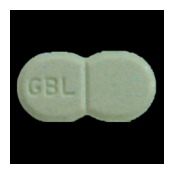

1A


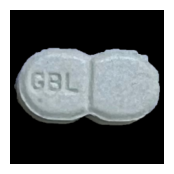

2A


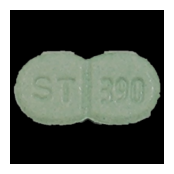

2B


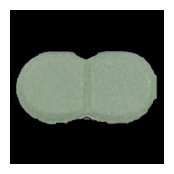

3A


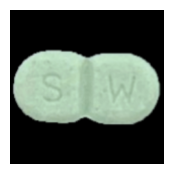

3B


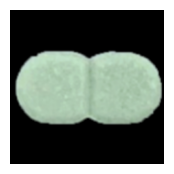

1/1 [==============================] - 0s 31ms/step
388
Predicted class: p_dou_048068
---feature_extractor---
SimilarityS1A + 1A: 0.52349997
SimilarityS1A + 2A: 0.48670402
SimilarityS1A + 2B: 0.53448415
SimilarityS1A + 3A: 0.6906009
SimilarityS1A + 3B: 0.6776746
EucS1A + 1A : 32.119648
EucS1A + 2A : 36.088398
EucS1A + 2B : 35.29767
EucS1A + 3A : 27.41558
EucS1A + 3B : 28.631298
---model---
SimilarityS1A + 1A: 0.09660121
SimilarityS1A + 2A: 0.21984221
SimilarityS1A + 2B: 0.2795087
SimilarityS1A + 3A: 0.9722354
SimilarityS1A + 3B: 0.9721503


In [8]:
#藥丸種類-3
print("S1A")
img1 = load_and_preprocess_image('TestImg/pill/3/Sample_10_1_A_G.png')
print("1A")
img2 = load_and_preprocess_image('TestImg/pill/3/10_1_A_G.png')
print("2A")
img3 = load_and_preprocess_image('TestImg/pill/3/10_2_A_G.png')
print("2B")
img4 = load_and_preprocess_image('TestImg/pill/3/10_2_B_G.png')
print("3A")
img5 = load_and_preprocess_image('TestImg/pill/3/10_3_A_G.png')
print("3B")
img6 = load_and_preprocess_image('TestImg/pill/3/10_3_B_G.png')

predictions1 = model.predict(img1)
predicted_class_index1 = np.argmax(predictions1)
print(predicted_class_index1)
predicted_class_name1 = class_labels[predicted_class_index1]

print(f"Predicted class: {predicted_class_name1}")

#for inceptionv3
print("---feature_extractor---")
features1 = feature_extractor.predict(img1,verbose=0).flatten()
features2 = feature_extractor.predict(img2,verbose=0).flatten()
features3 = feature_extractor.predict(img3,verbose=0).flatten()
features4 = feature_extractor.predict(img4,verbose=0).flatten()
features5 = feature_extractor.predict(img5,verbose=0).flatten()
features6 = feature_extractor.predict(img6,verbose=0).flatten()
similarity1 = cosine_similarity([features1], [features2])[0][0]
similarity2 = cosine_similarity([features1], [features3])[0][0]
similarity3 = cosine_similarity([features1], [features4])[0][0]
similarity4 = cosine_similarity([features1], [features5])[0][0]
similarity5 = cosine_similarity([features1], [features6])[0][0]
print("SimilarityS1A + 1A:", similarity1)
print("SimilarityS1A + 2A:", similarity2)
print("SimilarityS1A + 2B:", similarity3)
print("SimilarityS1A + 3A:", similarity4)
print("SimilarityS1A + 3B:", similarity5)

#通用
euc1 = calculate_euclidean_distance(features1, features2)
euc2 = calculate_euclidean_distance(features1, features3)
euc3 = calculate_euclidean_distance(features1, features4)
euc4 = calculate_euclidean_distance(features1, features5)
euc5 = calculate_euclidean_distance(features1, features6)
print("EucS1A + 1A :", euc1)
print("EucS1A + 2A :", euc2)
print("EucS1A + 2B :", euc3)
print("EucS1A + 3A :", euc4)
print("EucS1A + 3B :", euc5)

#for resnet50 + triplet loss
print("---model---")
features1 = model.predict(img1,verbose=0)
features2 = model.predict(img2,verbose=0)
features3 = model.predict(img3,verbose=0)
features4 = model.predict(img4,verbose=0)
features5 = model.predict(img5,verbose=0)
features6 = model.predict(img6,verbose=0)
similarity1 = cosine_similarity(features1, features2)[0][0]
similarity2 = cosine_similarity(features1, features3)[0][0]
similarity3 = cosine_similarity(features1, features4)[0][0]
similarity4 = cosine_similarity(features1, features5)[0][0]
similarity5 = cosine_similarity(features1, features6)[0][0]
print("SimilarityS1A + 1A:", similarity1)
print("SimilarityS1A + 2A:", similarity2)
print("SimilarityS1A + 2B:", similarity3)
print("SimilarityS1A + 3A:", similarity4)
print("SimilarityS1A + 3B:", similarity5)

In [8]:
#SIFT-不準確
image1 = cv2.imread('TestImg/pill/1/Sample_8_1_A_W.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('TestImg/pill/1/8_1_A_W.jpg', cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

similarity = sum([match.distance for match in matches]) / len(matches)
print("SIFT Similarity:", similarity)

SIFT Similarity: 186.0119171142578


In [9]:
#輪廓
image1 = cv2.imread('TestImg/pill/1/Sample_8_1_A_W.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('TestImg/pill/1/8_1_A_W.jpg', cv2.IMREAD_GRAYSCALE)

_, binary1 = cv2.threshold(image1, 250, 255, cv2.THRESH_BINARY)
_, binary2 = cv2.threshold(image2, 250, 255, cv2.THRESH_BINARY)

contours1, _ = cv2.findContours(binary1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image1 = cv2.drawContours(image1, contours1, -1, (0,255,0), 3)
image2 = cv2.drawContours(image2, contours2, -1, (0,255,0), 3)

cv2.imshow('Contours', image1) 
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow('Contours2', image2) 
cv2.waitKey(0)
cv2.destroyAllWindows()

contour1 = contours1[0]
contour2 = contours2[0]

similarity = cv2.matchShapes(contour1, contour2, cv2.CONTOURS_MATCH_I1, 0.0)

print("Shape Similarity:", similarity)

Shape Similarity: 1.7976931348623157e+308


In [11]:
#ORB -特徵不足會產生空值
import cv2

image1 = cv2.imread('TestImg/pill/1/Sample_8_1_A_W.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('TestImg/pill/1/8_1_A_W.jpg', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

similarity = sum([match.distance for match in matches]) / len(matches)

print("ORB Similarity:", similarity)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\batch_distance.cpp:275: error: (-215:Assertion failed) type == src2.type() && src1.cols == src2.cols && (type == CV_32F || type == CV_8U) in function 'cv::batchDistance'


In [1]:
import os
import numpy as np
import keras.utils as image
from keras.applications.efficientnet_v2 import EfficientNetV2S, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import cv2
import matplotlib.pyplot as plt

In [7]:
# Load and preprocess image function
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(384, 384))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to calculate feature vector from image using the model
def get_features(img_path, model):
    img_array = load_and_preprocess_image(img_path)
    features = model.predict(img_array, verbose=0).flatten()
    return features

# Function to process all images in a folder and compute similarity to a template image
def process_images_in_folder(template_img_path, folder_path, model):
    # Get features of the template image
    template_features = get_features(template_img_path, model)
    
    # List to store similarity results
    similarities = {}
    
    # Iterate through all images in the folder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        
        if os.path.isfile(img_path):
            print(f"Processing: {filename}")
            
            # Get features of the current image
            img_features = get_features(img_path, model)
            
            # Calculate cosine similarity between template and current image
            similarity = cosine_similarity([template_features], [img_features])[0][0]
            similarities[filename] = similarity
    
    return similarities

In [8]:
# Set the model
model = EfficientNetV2S(weights='imagenet', include_top=False)  # Best model for your case

# Example usage: Folder containing images to compare with the template image
template_img_path = 'TestImg/pill/2/Sample_9_1_B_W_T.png'
folder_path = 'TestImg/pill/2/'

# Get similarity scores for all images in the folder
similarities = process_images_in_folder(template_img_path, folder_path, model)

# Print out similarity scores
for filename, similarity in similarities.items():
    print(f"Similarity between {template_img_path} and {filename}: {similarity}")

Processing: 9_1_A_W.png
Processing: 9_1_B_W.png
Processing: 9_2_A_W.png
Processing: 9_2_B_W.png
Processing: 9_3_A_W.png
Processing: 9_3_B_W.png
Processing: Sample_9_1_A_W.png
Processing: Sample_9_1_A_W_T.png
Processing: Sample_9_1_B_W.png
Processing: Sample_9_1_B_W_T.png
Similarity between TestImg/pill/2/Sample_9_1_B_W_T.png and 9_1_A_W.png: 0.25111955404281616
Similarity between TestImg/pill/2/Sample_9_1_B_W_T.png and 9_1_B_W.png: 0.2116847187280655
Similarity between TestImg/pill/2/Sample_9_1_B_W_T.png and 9_2_A_W.png: 0.16081461310386658
Similarity between TestImg/pill/2/Sample_9_1_B_W_T.png and 9_2_B_W.png: 0.1459059715270996
Similarity between TestImg/pill/2/Sample_9_1_B_W_T.png and 9_3_A_W.png: 0.19903281331062317
Similarity between TestImg/pill/2/Sample_9_1_B_W_T.png and 9_3_B_W.png: 0.18349218368530273
Similarity between TestImg/pill/2/Sample_9_1_B_W_T.png and Sample_9_1_A_W.png: 0.196282297372818
Similarity between TestImg/pill/2/Sample_9_1_B_W_T.png and Sample_9_1_A_W_T.png: 

In [5]:
tmp = '衛署藥製字第057107號-20230616-001_object_1.png'
x = tmp.split("-")[0]
print(x)

衛署藥製字第057107號
